# 2B

In [1168]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import time
import joblib
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Lasso
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as preprocessing

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas._libs.parsers import k
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold


random_state = 42

In [1169]:
mvp_stats_2b = pd.read_csv("datasets/player_mvp_stats.csv", ';')
nicknames_df = pd.read_csv("datasets/nicknames.csv", ';')
salaries_2b = pd.read_csv("datasets/salaries.csv")
teams_2b = pd.read_csv("datasets/teams.csv", ';')
us_inflation_2b = pd.read_csv("datasets/US CPI.csv")

C:\Users\imman\AppData\Local\Temp\ipykernel_16180\3205523321.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  mvp_stats_2b = pd.read_csv("datasets/player_mvp_stats.csv", ';')
C:\Users\imman\AppData\Local\Temp\ipykernel_16180\3205523321.py:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  nicknames_df = pd.read_csv("datasets/nicknames.csv", ';')
C:\Users\imman\AppData\Local\Temp\ipykernel_16180\3205523321.py:4: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  teams_2b = pd.read_csv("datasets/teams.csv", ';')


In [1170]:
players_height_2b = pd.read_csv("datasets/all_seasons.csv")
players_height_2b = players_height_2b[["player_name", "player_weight", "player_height", "season"]]

In [1171]:
# rename kolom supaya namanya tidak misleading
salaries_2b.rename({"Rank": "Salaries_Rank"}, axis=1, inplace=True)

### 2B. Preprocess dan merge beberapa dataset menjadi satu

In [1172]:
def dataframe_to_dict(nicknames_df, key_column_name='Name', value_column_name='Abbreviation'):
    keys = nicknames_df[key_column_name]
    values = nicknames_df[value_column_name]
    return dict(zip(keys, values))

##### Pre-process dan cleaning teams dataset

In [1173]:
def cleaning_teamsdf_removeUnimportantRows(teams_2b):
    teams_2b = teams_2b.copy()
    important_rows = ~teams_2b.W.str.contains("Division")
    return teams_2b[important_rows]

def cleaning_teamsdf_convertStripToNan(teams_2b):
    teams_2b = teams_2b.copy()
    teams_2b.GB = teams_2b.GB.replace("—", np.NAN)
    return teams_2b

def cleaning_teamsdf_convertToAppropriateDatatype(teams_2b):
    """
    preconditions:
        cleaning_teamsdf_removeUnimportantRows
         cleaning_teamsdf_convertStripToNan
    """
    teams_2b = teams_2b.copy()
    teams_2b.W = pd.to_numeric(teams_2b.W)
    teams_2b.L = pd.to_numeric(teams_2b.L)
    teams_2b['W/L%'] = pd.to_numeric(teams_2b['W/L%'])
    teams_2b.GB = pd.to_numeric(teams_2b.GB)
    teams_2b['PS/G'] = pd.to_numeric(teams_2b['PS/G'])
    teams_2b['PA/G'] = pd.to_numeric(teams_2b['PA/G'])
    teams_2b.SRS = pd.to_numeric(teams_2b.SRS)
    return teams_2b


def cleaning_anyDf_removeStarInTeamName(teams_2b, column_name='Team'):
    teams_2b = teams_2b.copy()
    teams_2b[column_name] = teams_2b[column_name].str.replace('*', '')
    return teams_2b


def cleaning_anyDf_convertTeamNamesToItsAbbrev(teams_2b, nicknames_df, column_name='Team'):
    """
    precondition:
        teams df:
            cleaning_anyDf_removeStarInTeamName
    """
    nicknames_df = nicknames_df.copy()
    teams_2b = teams_2b.copy()

    nicknames_df = nicknames_df.drop_duplicates(subset='Name', keep='first')
    mapping = dataframe_to_dict(nicknames_df)
    mapping |= dataframe_to_dict(nicknames_df, 'Abbreviation', 'Abbreviation')

    teams_2b[column_name] = list(map(
        lambda x: mapping[x],
        teams_2b[column_name]
    ))
    return teams_2b


In [1174]:
teams_2b = cleaning_teamsdf_removeUnimportantRows(teams_2b)
teams_2b = cleaning_teamsdf_convertStripToNan(teams_2b)
teams_2b = cleaning_teamsdf_convertToAppropriateDatatype(teams_2b)
teams_2b = cleaning_anyDf_removeStarInTeamName(teams_2b)
teams_2b = cleaning_anyDf_convertTeamNamesToItsAbbrev(teams_2b, nicknames_df)
teams_2b

C:\Users\imman\AppData\Local\Temp\ipykernel_16180\1825840574.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  teams_2b[column_name] = teams_2b[column_name].str.replace('*', '')


,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,56,26,683.0,NaN,111.5,105.7,5.22,1991,BOS
1,44,38,537.0,12.0,105.4,105.6,-0.39,1991,PHI
2,39,43,476.0,17.0,103.1,103.3,-0.43,1991,NYK
3,30,52,366.0,26.0,101.4,106.4,-4.84,1991,WSB
4,26,56,317.0,30.0,102.9,107.5,-4.53,1991,NJN
...,...,...,...,...,...,...,...,...,...
1028,42,30,583.0,NaN,112.4,110.2,2.26,2021,DAL
1029,38,34,528.0,4.0,113.3,112.3,1.07,2021,MEM
1030,33,39,458.0,9.0,111.1,112.8,-1.58,2021,SAS
1031,31,41,431.0,11.0,114.6,114.9,-0.20,2021,NOP


##### Pre-process dan cleaning players height dataset

In [1175]:
def cleaning_playersHeightDf_convertSeasonToYear(players_height_2b):
    players_height_2b = players_height_2b.copy()
    players_height_2b['Year'] = players_height_2b.season.apply(lambda x: x.split("-")[0])
    players_height_2b.Year = pd.to_numeric(players_height_2b.Year)
    players_height_2b.drop('season', axis=1, inplace=True)
    return players_height_2b

In [1176]:
cleaned_players_height_2b = cleaning_playersHeightDf_convertSeasonToYear(players_height_2b)
cleaned_players_height_2b.rename({"player_name": "Player_name"}, axis=1, inplace=True)

##### Pre-process dan cleaning inflation dataset

In [1177]:
from datetime import datetime


def cleaning_inflationDf_separateDateColumns(us_inflation_2b, column='Yearmon', format="%d-%m-%Y"):
    us_inflation_2b = us_inflation_2b.copy()

    dates = []
    for i in range(len(us_inflation_2b)):
        date = us_inflation_2b[column].iloc[i]
        date = datetime.strptime(date, format)
        dates.append(date)
    us_inflation_2b['Year']  = [date.year for date in dates]
    us_inflation_2b['Month'] = [date.month for date in dates]
    us_inflation_2b['Day']   = [date.day for date in dates]

    return us_inflation_2b


def cleaning_inflationDf_getYearByMedian(us_inflation_2b):
    """
    precondition: cleaning_inflationDf_separateDateColumns
    """
    us_inflation_2b = us_inflation_2b.copy()
    us_inflation_2b = cleaning_inflationDf_separateDateColumns(us_inflation_2b)
    us_inflation_2b = us_inflation_2b.groupby(by='Year')['CPI'].median()
    us_inflation_2b = us_inflation_2b.reset_index()
    return us_inflation_2b


def cleaning_anyDf_removeDuplicatedColumns(combined_df):
    combined_df = combined_df.copy()
    columns = combined_df.columns

    columns_tobe_removed = []
    for i in range(len(columns)):
        col1 = columns[i]
        for j in range(i+1, len(columns)):
            col2 = columns[j]

            if (combined_df[col1] == combined_df[col2]).all():
                columns_tobe_removed.append(col1)
    columns_tobe_kept = set(combined_df.columns) - set(columns_tobe_removed)
    columns_tobe_kept = list(columns_tobe_kept)
    return combined_df.loc[:, columns_tobe_kept]

def cleaning_anyDf_recalculateWLpercentage(teams_2b):
    """
    Nilai W/L% pada dataset CSV banyak yang ambigu dan kurang konsisten. Jadi lebih baik dihitung ulang saja.
    """
    teams_2b = teams_2b.copy()
    teams_2b['W/L%'] = 100*teams_2b.W / (teams_2b.W + teams_2b.L)
    return teams_2b

In [1178]:
us_inflation_2b.head()

,Yearmon,CPI
0,01-01-1913,9.8
1,01-02-1913,9.8
2,01-03-1913,9.8
3,01-04-1913,9.8
4,01-05-1913,9.7


Pada kasus ini kami memutuskan mengambil median dari inflasi karena CPI merupakan perbandingan inflasi pada tahun ini dengan inflasi pada suatu tahun yang dijadikan pivot. Karena CPI merupakan suatu perbandingan, maka kami merasa bahwa mengambil median lebih tepat dibandingkan mengambil mean-nya.

In [1179]:
us_inflation_2b_cleaned = us_inflation_2b.copy()
us_inflation_2b_cleaned = cleaning_inflationDf_separateDateColumns(us_inflation_2b_cleaned)
us_inflation_2b_cleaned = cleaning_inflationDf_getYearByMedian(us_inflation_2b_cleaned)

##### Merging dataframes

In [1180]:
combined_df = us_inflation_2b_cleaned.merge(teams_2b, left_on=["Year"], right_on=["Year"])
combined_df = cleaning_anyDf_recalculateWLpercentage(combined_df)
print("Size: ", combined_df.shape)
combined_df.head(3)

Size:  (906, 10)


,Year,CPI,W,L,W/L%,GB,PS/G,PA/G,SRS,Team
0,1991,136.1,56,26,68.292683,NaN,111.5,105.7,5.22,BOS
1,1991,136.1,44,38,53.658537,12.0,105.4,105.6,-0.39,PHI
2,1991,136.1,39,43,47.560976,17.0,103.1,103.3,-0.43,NYK


In [1181]:
mvp_stats_2b = mvp_stats_2b.drop('Tm', axis=1)  # karena sudah ada kolom Team
mvp_stats_2b = cleaning_anyDf_convertTeamNamesToItsAbbrev(mvp_stats_2b, nicknames_df)

In [1182]:
display(mvp_stats_2b.head(2))
display(combined_df.head(2))
print('banyaknya null salaries: ', salaries_2b.Salaries.isna().sum())
print('banyaknya null player name salaries: ', salaries_2b.Name.isna().sum())
print('banyaknya null player name mvp stats: ', mvp_stats_2b.Player.isna().sum())
print('banyaknya null team name: ', combined_df.Team.isna().sum())
print()
print('banyaknya row salaries df : ', len(salaries_2b))
print('banyaknya row mvp statsdf : ', len(mvp_stats_2b))
print('banyaknya row combined df : ', len(combined_df))

,Player,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,A.C. Green,PF,27,82,21,26.4,3.1,6.6,476.0,0.1,...,0,0.0,LAL,58,24,707.0,5.0,106.3,99.6,6.73
1,Byron Scott,SG,29,82,82,32.1,6.1,12.8,477.0,0.9,...,0,0.0,LAL,58,24,707.0,5.0,106.3,99.6,6.73


,Year,CPI,W,L,W/L%,GB,PS/G,PA/G,SRS,Team
0,1991,136.1,56,26,68.292683,NaN,111.5,105.7,5.22,BOS
1,1991,136.1,44,38,53.658537,12.0,105.4,105.6,-0.39,PHI


banyaknya null salaries:  28074
banyaknya null player name salaries:  0
banyaknya null player name mvp stats:  0
banyaknya null team name:  0

banyaknya row salaries df :  37420
banyaknya row mvp statsdf :  14092
banyaknya row combined df :  906


In [1183]:
salaries_2b = salaries_2b.drop("Unnamed: 0", axis=1)

combined_df = mvp_stats_2b.merge(combined_df, left_on=["Team", "Year"], right_on=["Team", "Year"])
combined_df = salaries_2b.merge(combined_df, left_on=["Name", "Year"], right_on=["Player", "Year"])
combined_df = cleaning_anyDf_removeDuplicatedColumns(combined_df)
combined_df = combined_df.rename({"Player": "Player_name"}, axis=1)

combined_df.head(5)

,Pos,PTS,Salaries,FTA,ORB,TRB,Age,Year,Pts Won,GB_y,...,G,PS/G_y,CPI,DRB,FGA,GB_x,TOV,FT%,3P,BLK
0,C,29.7,17142000.0,10.4,4.3,13.6,27,2000,1207,NaN,...,79,100.8,172.6,9.4,21.1,0.0,2.8,524.0,0.0,3.0
1,PF,22.9,16806000.0,5.0,2.8,11.8,23,2000,408,5.0,...,81,98.5,172.6,9.0,18.8,5.0,3.3,765.0,0.4,1.6
2,C,21.7,15004000.0,7.4,2.7,9.5,29,2000,367,NaN,...,79,94.4,172.6,6.8,15.0,0.0,2.7,711.0,0.0,3.7
3,PF,14.9,15000000.0,3.4,1.6,5.7,26,2000,0,23.0,...,82,96.6,172.6,4.1,13.5,23.0,2.7,735.0,0.0,0.3
4,SF,12.5,14795000.0,2.7,1.4,6.3,34,2000,0,8.0,...,82,97.5,172.6,4.9,10.5,8.0,2.5,717.0,1.0,0.5


In [1184]:
print("Banyaknya row: ", combined_df.shape)
print("Banyaknya data duplikat: ", combined_df.duplicated().sum())

Banyaknya row:  (8323, 45)
Banyaknya data duplikat:  0


In [1185]:
combined_df = combined_df.merge(cleaned_players_height_2b, left_on=["Player_name", "Year"], right_on=["Player_name", "Year"])

In [1186]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6740 entries, 0 to 6739
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pos            6740 non-null   object 
 1   PTS            6740 non-null   float64
 2   Salaries       6453 non-null   float64
 3   FTA            6740 non-null   float64
 4   ORB            6740 non-null   float64
 5   TRB            6740 non-null   float64
 6   Age            6740 non-null   int64  
 7   Year           6740 non-null   int64  
 8   Pts Won        6740 non-null   int64  
 9   GB_y           5391 non-null   float64
 10  Salaries_Rank  6740 non-null   int64  
 11  3P%            5933 non-null   float64
 12  eFG%           6733 non-null   float64
 13  SRS_y          6740 non-null   float64
 14  FG%            6733 non-null   float64
 15  L_y            6740 non-null   int64  
 16  2P             6740 non-null   float64
 17  STL            6740 non-null   float64
 18  Player_n

### 2B. Visualisasi Data

In [1187]:
pca = PCA(n_components=3)

scaler = MinMaxScaler()
temp_df = combined_df.drop(["Team", "Player_name", "Pos"], axis=1).dropna()
temp_df = pd.DataFrame(
    scaler.fit_transform(temp_df),
    columns=temp_df.columns
)
transformed_pca = pca.fit_transform(X=temp_df)
transformed_pca = pd.DataFrame(transformed_pca)

print("Cumulative sum of explained ratio: ")
print(np.cumsum(pca.explained_variance_ratio_))

Cumulative sum of explained ratio: 
[0.26544491 0.422833   0.55325416]


Text(0.5, 1.0, 'Scatterplot antara PCA-0 dengan Salaries')

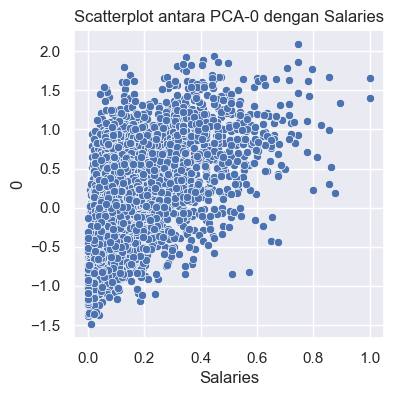

In [1188]:
sns.set(rc={'figure.figsize':(4,4)})
sns.scatterplot(x=temp_df.Salaries, y=transformed_pca[0])
plt.title("Scatterplot antara PCA-0 dengan Salaries")

Text(0.5, 1.0, 'Scatterplot antara PCA-1 dengan Salaries')

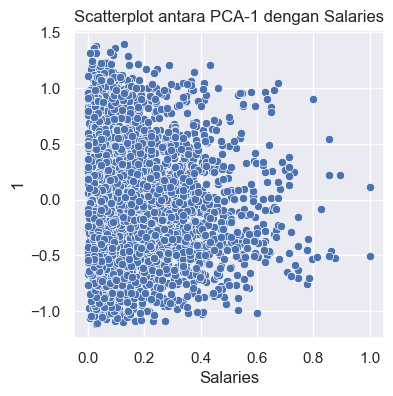

In [1189]:
sns.scatterplot(x=temp_df.Salaries, y=transformed_pca[1])
plt.title("Scatterplot antara PCA-1 dengan Salaries")

Text(0.5, 1.0, 'Scatterplot antara PCA-2 dengan Salaries')

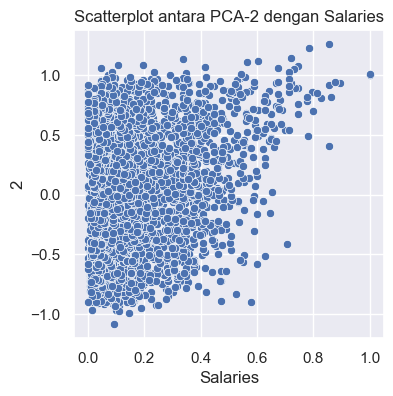

In [1190]:
sns.scatterplot(x=temp_df.Salaries, y=transformed_pca[2])
plt.title("Scatterplot antara PCA-2 dengan Salaries")

In [1191]:
correlation_target_and_pca = transformed_pca.apply(lambda x: x.corr(temp_df.Salaries))
print("Correlation between PCA and Salaries:")
print(correlation_target_and_pca)

Correlation between PCA and Salaries:
0    0.592461
1   -0.090135
2    0.233511
dtype: float64


Text(0.5, 1.0, 'Besar korelasi (mutlak) masing-masing kolom dengan Salaries')

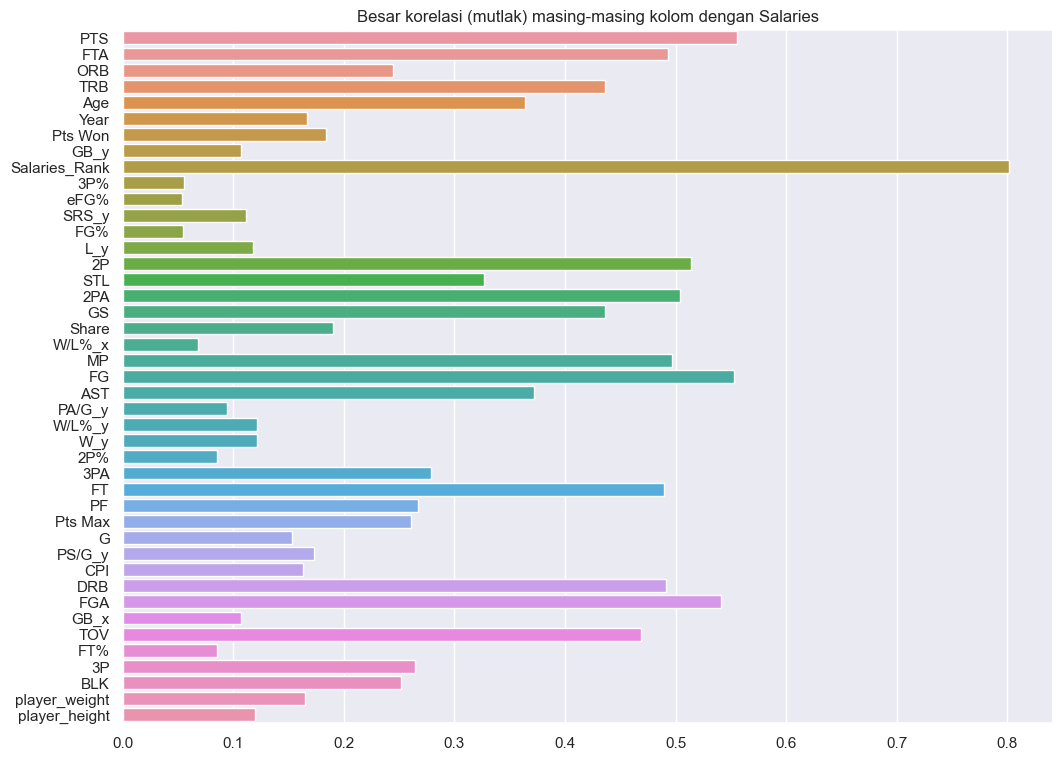

In [1192]:
salaries = temp_df.Salaries
temp_df2 = temp_df.drop('Salaries', axis=1)
correlation_target_and_all_columns = temp_df2.apply(lambda x: x.corr(salaries))

sns.set(rc={'figure.figsize':(12,9)})
sns.barplot(y=temp_df2.columns, x=abs(correlation_target_and_all_columns), orient="h")
plt.title("Besar korelasi (mutlak) masing-masing kolom dengan Salaries")

### 2B. Drop missing values pada target feature

kami memutuskan untuk mendrop missing values pada target feature karena target feature merupakan ground truth. Oleh karena itu, kami tidak setuju apabila kita melakukan imputasi untuk missing values pada kolom ini. Sebab, apabila kita melakukan imputasi terhadap missing values untuk kolom ini, maka kolom ini tidak sepenuhnya menjadi ground truth lagi karena diisikan dengan data-data sintesis yang tidak diketahui kebenarannya.

In [1193]:
print("Banyak missing values pada kolom Salaries sebelum drop: ", combined_df.Salaries.isna().sum())
combined_df = combined_df[combined_df.Salaries.notna()]
print("Banyak missing values pada kolom Salaries setelah drop: ", combined_df.Salaries.isna().sum())

Banyak missing values pada kolom Salaries sebelum drop:  287
Banyak missing values pada kolom Salaries setelah drop:  0


### 2B. Memisahkan kolom-kolom menjadi feature (X) dan target (y) dan drop fitur-fitur yang tidak diperlukan

Pada dataset ini, kita sudah memiliki gabungan seluruh feature mengenai statistik performa team dan statistik performa pemain. Oleh karena itu, nama tim dan nama pemain sudah tidak lagi berkaitan dengan gaji yang diperoleh. Nama tim sudah dapat digantikan dengan data mengenai performa tim, dan nama pemain dapat digantikan dengan data mengenai performa pemain.

Sementara itu, kita melakukan drop kolom Rank karena kolom tersebut merupakan Ranking gaji seorang pemain pada tahun itu. Oleh karena itu, kami merasa informasi ini tidak valid untuk dijadikan dasar dalam memprediksi gaji pemain.

In [1194]:
x_2b, y_2b = combined_df.drop("Salaries", axis=1), combined_df[["Salaries"]]
x_2b.drop("Team", axis=1, inplace=True)
x_2b.drop("Player_name", axis=1, inplace=True)
x_2b.drop("Salaries_Rank", axis=1, inplace=True)

display(x_2b.head(2))
display(y_2b.head(2))

,Pos,PTS,FTA,ORB,TRB,Age,Year,Pts Won,GB_y,3P%,...,CPI,DRB,FGA,GB_x,TOV,FT%,3P,BLK,player_weight,player_height
0,C,29.7,10.4,4.3,13.6,27,2000,1207,NaN,0.00,...,172.6,9.4,21.1,0.0,2.8,524.0,0.0,3.0,142.88148,215.90
1,PF,22.9,5.0,2.8,11.8,23,2000,408,5.0,0.37,...,172.6,9.0,18.8,5.0,3.3,765.0,0.4,1.6,99.79024,210.82


,Salaries
0,17142000.0
1,16806000.0


### 2B. Membagi dataset menjadi training, testing, dan final testing

Kami memutuskan untuk membagi dataset menjadi training, testing, dan final testing. Dataset final testing diperlukan karena kita sangat disarankan untuk memasuki fase testing hanya sekali saja, yakni ketika kita sudah benar-benar yakin dengan model yang kita bangun dan sudah tidak ingin mengutak-atik modelnya lagi. Oleh karena itu, kami memutuskan untuk membagi dataset testing menjadi testing untuk mengecek performa, dan final testing untuk model yang sudah final.

In [1195]:
x_2b_train, x2b_final_test, y_2b_train, y_2b_final_test = train_test_split(
    x_2b, y_2b, test_size=0.2, random_state=random_state
)
del x_2b
del y_2b

x_2b_train, x_2b_test, y_2b_train, y_2b_test = train_test_split(
    x_2b_train, y_2b_train, test_size=0.2, random_state=random_state,
)

### 2B Pipeline Design, Training model, dan Hyperparameter tuning

Pada bagian ini, kita akan merancang pipeline mengenai alur pemrosesan data. Pipeline ini memiliki 5 tahapan: *encode* data kategorikal, menerapkan *scaling* & *standarisasi*, mengisi *missing values*, menerapkan *feature selection* , dan melakukan *training*/prediksi.

Beberapa tahapan dapat memiliki beberapa alternatif yang ingin dicoba. Misalnya, pada tahapan standarisasi kami mencoba metode MinMaxScaler, StandardScaler, RobustScaler, dan tanpa scaling. Setelah itu kami akan memilih metode yang menghasilkan akurasi terbaik. Oleh karena itu, kami akan memanfaatkan `GridSearchCV` untuk mencoba semua kombinasi tersebut.

Pada bagian ini, kami mempertimbangkan untuk tidak menghapus outlier karena kami mengasumsikan bahwa outlier pada dataset memang merupakan sifat alami dari data dan tidak diakibatkan oleh kesalahan pengukuran apapun. Karena outlier tersebut merupakan data alami, akan lebih baik apabila kami membiarkannya saja.

In [1196]:
def cartesian_product_of_dict_lists(*multiple_list_of_dicts):
    if len(multiple_list_of_dicts) == 0:
        return []

    if len(multiple_list_of_dicts) == 1:
        return multiple_list_of_dicts[0]

    if len(multiple_list_of_dicts) == 2:
        ret = []
        for dict1 in multiple_list_of_dicts[0]:
            for dict2 in multiple_list_of_dicts[1]:
                ret.append(dict(**dict1, **dict2))
        return ret

    curr = [{}]
    for dct in multiple_list_of_dicts:
        curr = cartesian_product_of_dict_lists(curr, dct)
    return curr

In [1197]:
class DataFrameCaptor(TransformerMixin):
    """Untuk mendapatkan contoh dataframe pada tahap tertentu di dalam pipeline"""
    def __init__(self):
        self.captured_fit_x = None
        self.captured_fit_y = None
        self.captured_transform_x = None
        self.captured_transform_y = None

    def fit(self, x, y=0):
        self.captured_fit_x = x
        self.captured_fit_y = y
        return self

    def transform(self, x, y=0):
        self.captured_transform_x = x
        self.captured_transform_y = y
        return x

    def get_captured_fit(self):
        return self.captured_fit_x, self.captured_fit_y

    def get_captured_transform(self):
        return self.captured_transform_x, self.captured_transform_y

Kami membuat salah satu metode encoding fitur kategorikal, yakni one-hot encoding dengan sedikit modifikasi. Pada dataset yang kami miliki, terdapat fitur `Pos`, yakni posisi pemain basket. Seorang pemain dapat memiliki satu ataupun dua posisi yang berbeda. Oleh karena itu, kami memodifikasi supaya one-hot encoding bisa memiliki nilai non-zero pada lebih dari satu kolom. Tetapi perlu diperhatikan bahwa urutan berpengaruh, sehingga Pos='SF-SG' berbeda dengan Pos='SG-SF'. Oleh karena itu, kami memutuskan untuk memberikan bobot yang berbeda-beda. Contohnya:
- Untuk Pos='C', maka setelah encoding, kolom C akan bernilai 1 dan kolom lainnya 0.
- Untuk Pos='SF-SG', maka setelah encoding, kolom SF akan bernilai 2/3, SG bernilai 1/3, dan kolom lainnya 0.
- Untuk Pos='SG-SF', maka setelah encoding, kolom SG akan bernilai 2/3, SF bernilai 1/3, dan kolom lainnya 0.

Deklarasi class di bawah ini akan menjalankan algoritma encoding tersebut.

In [1198]:
class OrderedMultiClassOneHotEncoder:
    def __init__(self, target_col="Pos",
                 base_classes=('C', 'PF', 'SF', 'PG', 'SG'),
                 separator="-"):
        self.target_col = target_col
        self.base_classes = base_classes
        self.separator = separator

    def fit(self, x, y=0):
        return self

    def _get_col_name(self, class_name):
        return f"{self.target_col}_{class_name}"

    def transform(self, x, y=0):
        column_values = x[self.target_col]
        x = x.drop(self.target_col, axis=1)
        for base_class in self.base_classes:
            x[self._get_col_name(base_class)] = 0

        for ind, val in enumerate(column_values):
            classes =  val.split(self.separator)
            weights = [i for i in range(len(classes), 0, -1)]  # len, len-1, len-2, ..., 2, 1
            sum_ = sum(weights)

            for class_, weight in zip(classes, weights):
                class_ = self._get_col_name(class_)
                col = x.columns.get_loc(class_)
                x.iloc[ind, col] = weight / sum_
        return x

Pada eksperimen sebelumnya, kami sudah mencoba membandingkan performa antara LabelEncoder dengan OrderedMultiClassOneHotEncoder. Hasilnya, OrderedMultiClassOneHotEncoder memberikan performa yang lebih baik dibandingkan LabelEncoder. Oleh karena itu, untuk menghemat biaya komputasi, kami memutuskan untuk menghapus LabelEncoder dari GridSearchCV.

In [1199]:
label_encoder_params = [{
    'encoding': [
        OrderedMultiClassOneHotEncoder("Pos", ['C', 'PF', 'SF', 'PG', 'SG'], "-"),
    ]
}]

In [1200]:
scaler1 = preprocessing.MinMaxScaler()
scaler2 = preprocessing.StandardScaler()
scaler3 = preprocessing.RobustScaler()

scaler_params = [{
    'scaler': [None, scaler1, scaler2, scaler3],
}]

In [1201]:
imputer1 = SimpleImputer()
imputer2 = KNNImputer()

imputer_params = [{
    'imputer': [imputer2, imputer1],
}]

Berikut ini kami mempertimbangkan SelectKBest untuk k bernilai 6 dan 7. Jumlahnya fitur yang dipilih disarankan adalah sqrt(N); N=banyaknya fitur. Oleh karena itu kami mencoba 6 dan 7 sebagai nilai k karena N=45; sqrt(N) sekitar 6 atau 7.

Source: https://datascience.stackexchange.com/a/11480/141286

In [1202]:
len(combined_df.columns)

47

In [1203]:
feature_selector_params = [{
    'feature_selector': [None]
}, {
    'feature_selector': [SelectFromModel(estimator=Lasso())],
    'feature_selector__estimator__alpha': [0.01]
}, {
    'feature_selector': [SelectKBest()],
    'feature_selector__k': [6, 7],
}, {
    'feature_selector': [PCA()],
    'feature_selector__n_components': ['mle']
}]

Kami sudah mencoba GridSearcCV untuk membandingkan model KNeighborsRegressor, LinearRegression, MLPRegressor (relu & tanh), dan RandomForestRegressor. Hasilnya, urutan model mulai dari yang terbaik hingga yang terburuk adalah RandomForestRegressor, LinearRegression, KNeighborsRegressor, dan MLPRegressor.

Setelah itu, kami juga sudah membandingkan RandomForestRegressor dengan SVR, BaggingRegressor(SVR()), BaggingRegressor(LinearRegression()), dan BaggingRegressor(KNeighborsRegressor()). Hasilnya, RandomForestRegressor masih tetap memberikan prediksi yang terbaik.

Oleh karena itu, di antara model-model yang sudah dicoba tersebut, kami mempertimbangkan untuk hanya memasukkan model RandomForestRegressor ke dalam GridSearchCV supaya menghemat biaya komputasi.

Setelah itu, kami mencoba RandomForestRegressor dengan min_samples_split 2 sampai 10. Hasilnya menunjukkan min_samples_split=5 memberikan akurasi terbaik. Oleh karena itu kami hanya akan mempertimbangkan min_samples_split=5 untuk dibandingkan dengan GradientBoostingRegressor

In [1204]:
predictor_params = [{
    'predictor': [
        RandomForestRegressor(random_state=random_state),
    ],
    'predictor__min_samples_split': [5,],
}, {
    'predictor': [
        GradientBoostingRegressor(random_state=random_state),
    ],
    'predictor__n_estimators': [100, 110, 120, 130],
}]

In [1205]:
pipeline = Pipeline(
    steps=[
        ('encoding', None),
        ('df_captor', DataFrameCaptor()),
        ('scaler', None),
        ('imputer', None),
        ('feature_selector', None),
        ('predictor', None),
    ]
)

In [1206]:
grid_params = cartesian_product_of_dict_lists(
    label_encoder_params,
    scaler_params,
    imputer_params,
    feature_selector_params,
    predictor_params
)

In [1207]:
grid_params

[{'encoding': [<__main__.OrderedMultiClassOneHotEncoder at 0x1aab1754190>],
  'scaler': [None, MinMaxScaler(), StandardScaler(), RobustScaler()],
  'imputer': [KNNImputer(), SimpleImputer()],
  'feature_selector': [None],
  'predictor': [RandomForestRegressor(random_state=42)],
  'predictor__min_samples_split': [5]},
 {'encoding': [<__main__.OrderedMultiClassOneHotEncoder at 0x1aab1754190>],
  'scaler': [None, MinMaxScaler(), StandardScaler(), RobustScaler()],
  'imputer': [KNNImputer(), SimpleImputer()],
  'feature_selector': [None],
  'predictor': [GradientBoostingRegressor(random_state=42)],
  'predictor__n_estimators': [100, 110, 120, 130]},
 {'encoding': [<__main__.OrderedMultiClassOneHotEncoder at 0x1aab1754190>],
  'scaler': [None, MinMaxScaler(), StandardScaler(), RobustScaler()],
  'imputer': [KNNImputer(), SimpleImputer()],
  'feature_selector': [SelectFromModel(estimator=Lasso())],
  'feature_selector__estimator__alpha': [0.01],
  'predictor': [RandomForestRegressor(random_s

In [1208]:
def perform_grid_search_cv():
    grid_search_cv = GridSearchCV(
        estimator=pipeline,
        param_grid=grid_params,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-2,
        verbose=10,
        error_score='raise',
    )

    grid_search_cv.fit(x_2b_train, y_2b_train.Salaries)
    return grid_search_cv

In [1209]:
file_name = "grid_search_cv_2b.pkl"
# Jika hasil GridSearchCV sudah tersimpan pada file, langsung dipakai saja. Jika belum, maka
# terapkan grid GridSearchCV
try:
    grid_search_cv = joblib.load(file_name)
except FileNotFoundError:
    # sekitar 20 menit pada laptop i7  6 core  24 GB
    start = time.time()
    grid_search_cv = perform_grid_search_cv()
    stop = time.time()

    print(f"GridSearchCV time: {int(stop - start)} seconds")
    joblib.dump(grid_search_cv, file_name)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
GridSearchCV time: 550 seconds


In [1210]:
# Get the scores for all hyperparameter combinations
cv_results = grid_search_cv.cv_results_
scores = []
for params_combination in cv_results['params']:
    score = cv_results['mean_test_score'][cv_results['params'].index(params_combination)]
    scores.append((score, params_combination))

# sort berdasarkan score terbesar (berdasarkan error yang terkecil)
scores.sort(reverse=True, key=lambda x: x[0])

print("Urutan parameter & model yang terbaik hingga terburuk: ")
print()
print()
# Print the scores for each combination
for score, params_combination in scores:
    print("Score: ", score)
    print(f"{params_combination}")
    print()

Urutan parameter & model yang terbaik hingga terburuk: 


Score:  -10370430275545.402
{'encoding': <__main__.OrderedMultiClassOneHotEncoder object at 0x000001AAB1754190>, 'feature_selector': None, 'imputer': KNNImputer(), 'predictor': GradientBoostingRegressor(n_estimators=110, random_state=42), 'predictor__n_estimators': 110, 'scaler': MinMaxScaler()}

Score:  -10370430275545.402
{'encoding': <__main__.OrderedMultiClassOneHotEncoder object at 0x000001AAB1754190>, 'feature_selector': SelectFromModel(estimator=Lasso()), 'feature_selector__estimator__alpha': 0.01, 'imputer': KNNImputer(), 'predictor': GradientBoostingRegressor(n_estimators=110, random_state=42), 'predictor__n_estimators': 110, 'scaler': MinMaxScaler()}

Score:  -10371277208190.947
{'encoding': <__main__.OrderedMultiClassOneHotEncoder object at 0x000001AAB1754190>, 'feature_selector': None, 'imputer': KNNImputer(), 'predictor': GradientBoostingRegressor(n_estimators=110, random_state=42), 'predictor__n_estimators': 120, '

### 2B testing

In [1211]:
def measure_accuracy(best_pipeline):
    y_2b_predict = best_pipeline.predict(x_2b_test)
    mae = metrics.mean_absolute_error(y_2b_test, y_2b_predict)
    r2 = metrics.r2_score(y_2b_test, y_2b_predict)

    print("R2 score: ", r2)
    print("Rata-rata error absolut: ", mae)
    print("Rata-rata error relatif: ", mae / y_2b_test.Salaries.mean())

In [1212]:
best_pipeline = grid_search_cv.best_estimator_
measure_accuracy(best_pipeline)

R2 score:  0.6432154184729799
Rata-rata error absolut:  2190105.3671206636
Rata-rata error relatif:  0.41716587148128415


In [1213]:
best_pipeline

Pipeline(steps=[('encoding',
                 <__main__.OrderedMultiClassOneHotEncoder object at 0x000001AAB97210C0>),
                ('df_captor',
                 <__main__.DataFrameCaptor object at 0x000001AAB9722260>),
                ('scaler', MinMaxScaler()), ('imputer', KNNImputer()),
                ('feature_selector', None),
                ('predictor',
                 GradientBoostingRegressor(n_estimators=110, random_state=42))])

In [1214]:
grid_search_cv.best_params_

{'encoding': <__main__.OrderedMultiClassOneHotEncoder at 0x1aab1754190>,
 'feature_selector': None,
 'imputer': KNNImputer(),
 'predictor': GradientBoostingRegressor(n_estimators=110, random_state=42),
 'predictor__n_estimators': 110,
 'scaler': MinMaxScaler()}

In [1215]:
feature_selector = best_pipeline['feature_selector']
if feature_selector is not None:
    captured_df, *_ = best_pipeline['df_captor'].get_captured_fit()

    print("Fitur-fitur terbaik: ")
    print()
    print(", ".join(
        feature_selector.get_feature_names_out(input_features=captured_df.columns)
    ))